In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

from util.collision_loss import torch_collision_check, NN_constraint_step
from util.zonotope import Zonotope, TorchZonotope
from util.constrained_zonotope import TorchConstrainedZonotope
from util.NN_con_zono import forward_pass_NN_torch, forward_pass_NN_con_zono_torch

# Feedforward network

In [2]:
# 3 Layer ReLU Feedforward Network
# 2 - 100 - 100 - 2

n_L1 = 10
n_L2 = 10

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, n_L2)  
        self.fc2 = nn.Linear(n_L1, n_L2)
        self.fc3 = nn.Linear(n_L2, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Use nonlinear function to generate data

In [3]:
# nonlinear function (vectorized)
def f_nonl(x):
    return np.array([x[:,0]**2 + np.sin(x[:,1]),
                     x[:,1]**2 + np.sin(x[:,0])])

# training set
N_train = 10000
X_train = np.random.uniform(-1, 1, (N_train,2))

# compute y's
Y_train = f_nonl(X_train)

X_train = torch.as_tensor(X_train, dtype=torch.float)
Y_train = torch.as_tensor(Y_train.T, dtype=torch.float)

In [4]:
# test set
N_test = 10000
X_test = np.random.uniform(-1, 1, (N_test,2))

# compute y's
Y_test = f_nonl(X_test)

X_test = torch.as_tensor(X_test, dtype=torch.float)
Y_test = torch.as_tensor(Y_test.T, dtype=torch.float)

In [5]:
# train the network
optimizer = optim.SGD(net.parameters(), lr=0.1)

loss = nn.MSELoss()

num_iters = 1000

# training loop:
for i in range(num_iters):
    optimizer.zero_grad()   # zero the gradient buffers

    pred = net(X_train)

    output = loss(pred, Y_train)
    #print('loss: ', output)
    output.backward()
    optimizer.step() 

Text(0.5, 1.0, 'Y test pred')

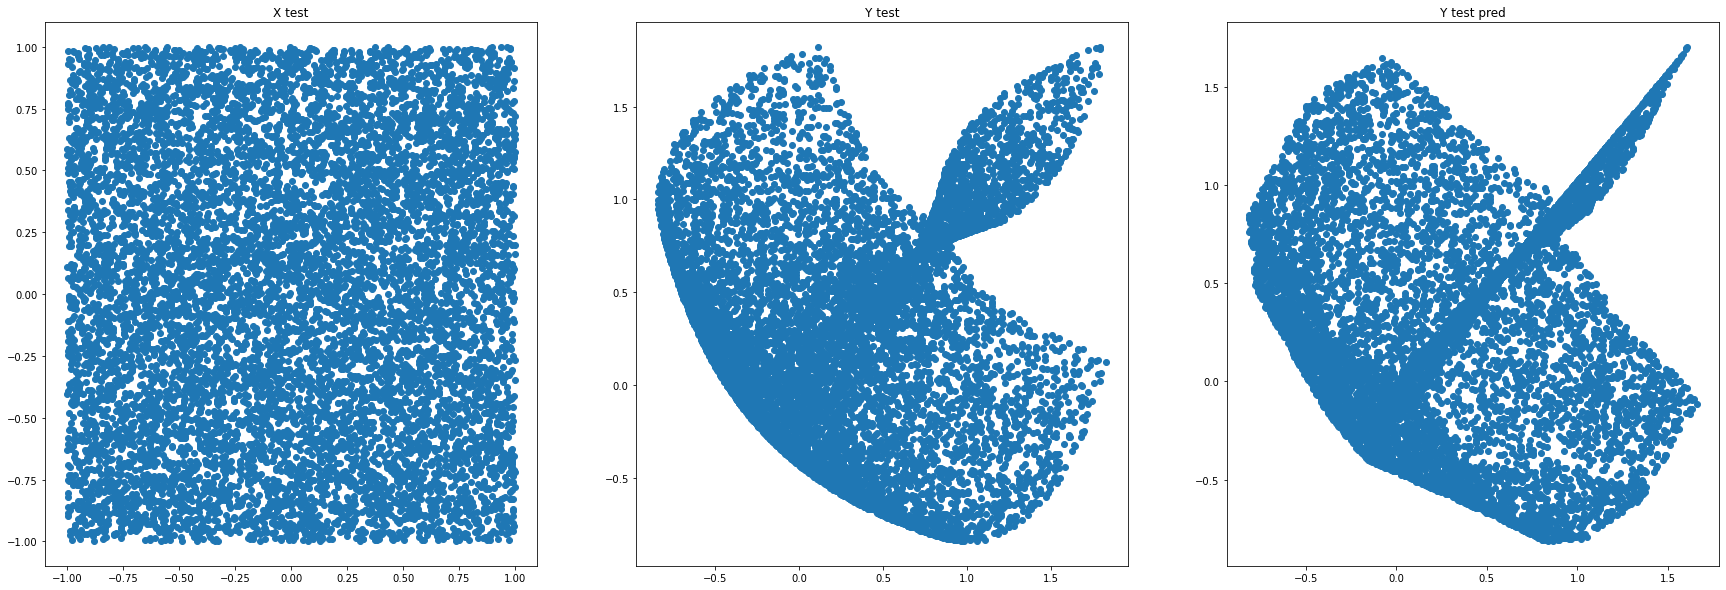

In [6]:
Y_test_pred = net(X_test)
test_loss = loss(Y_test_pred, Y_test)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.scatter(X_test[:,0], X_test[:,1]); ax1.set_title('X test')
ax2.scatter(Y_test[:,0], Y_test[:,1]); ax2.set_title('Y test')
ax3.scatter(Y_test_pred[:,0].detach().numpy(), Y_test_pred[:,1].detach().numpy()); ax3.set_title('Y test pred')

# Neural network reachability

In [44]:
# Toy 2 Layer network
# 2 - 10 - 2

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 10)  
        self.fc2 = nn.Linear(10, 2)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

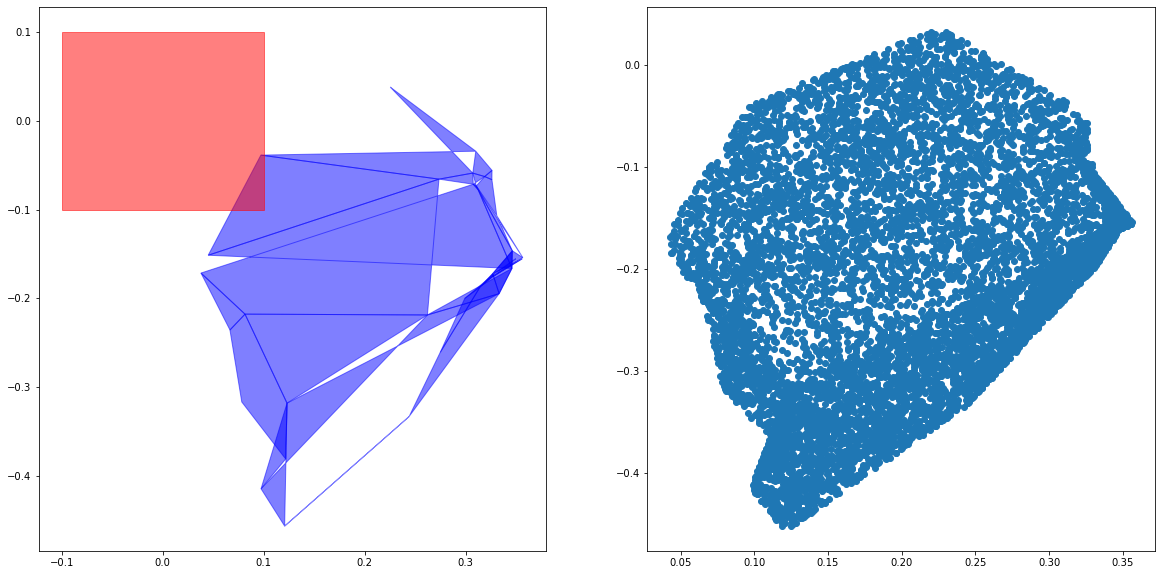

In [45]:
# input zonotope
Z_in = TorchZonotope(torch.zeros(2,1),torch.eye(2))

# output constraint zonotope ("obstacle")
c_obs = torch.tensor([[0.0],[0.0]])
G_obs = torch.diag(torch.tensor([0.1,0.1]))
Z_obs = TorchConstrainedZonotope(c_obs, G_obs)

# compute initial reachable set
Z_out = forward_pass_NN_torch(Z_in, net)

# plot zonotopes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
for z in Z_out:
    z.plot(ax1)
Z_obs.plot(ax1, 'r')
# plot samples
N_samples = 10000
X_in = np.random.uniform(-1, 1, (N_samples,2))
X_in = torch.as_tensor(X_in, dtype=torch.float)
Y_out = net(X_in)
ax2.scatter(Y_out[:,0].detach().numpy(), Y_out[:,1].detach().numpy())

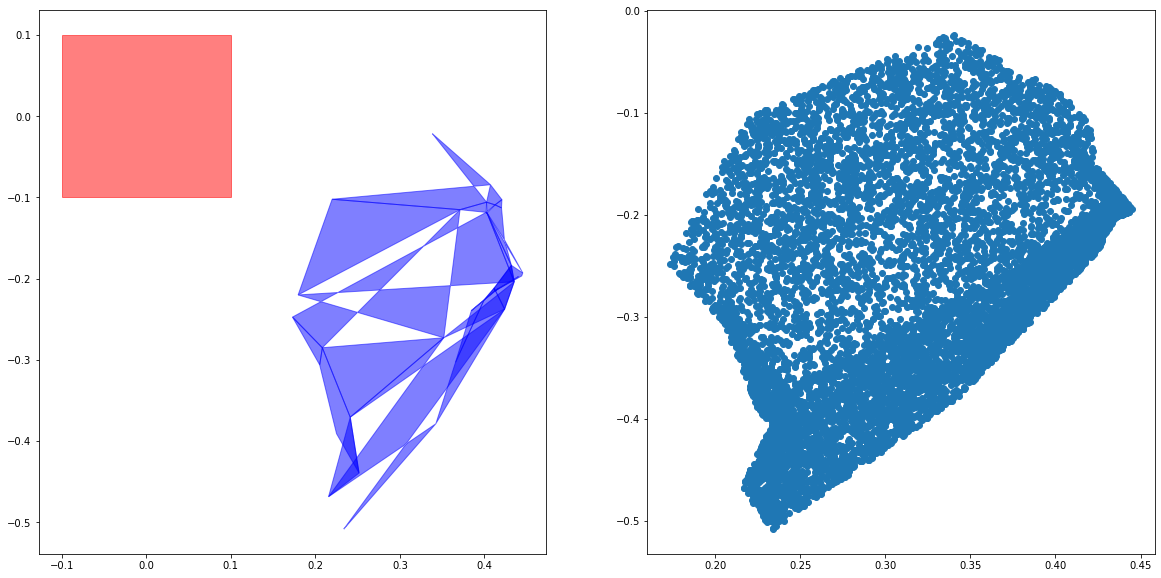

In [47]:
# constraint optimizer
con_opt = optim.SGD(net.parameters(), lr=0.1)

# # take a constraint step
NN_constraint_step(Z_in, Z_obs, net, con_opt)

# v = torch_collision_check(Z_out[0], Z_obs)
# print(v)
# con_opt.zero_grad()
# v.backward()
# con_opt.step()

# recompute reachable set
Z_out = forward_pass_NN_torch(Z_in, net)

# plot zonotopes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
for z in Z_out:
    z.plot(ax1)
Z_obs.plot(ax1, 'r')
# plot samples
N_samples = 10000
X_in = np.random.uniform(-1, 1, (N_samples,2))
X_in = torch.as_tensor(X_in, dtype=torch.float)
Y_out = net(X_in)
ax2.scatter(Y_out[:,0].detach().numpy(), Y_out[:,1].detach().numpy())

In [12]:
# extract weights and biases from network
NN_weights = []
NN_biases = []

idx = 0
for param in net.parameters():
    if idx % 2 == 0: # "even" parameters are weights
        NN_weights.append(param)
    else: # "odd" parameters are biases
        NN_biases.append(param[:,None])
    idx += 1

In [23]:
t_start = timer()
#Z_out = forward_pass_NN_con_zono_torch(Z_in, NN_weights, NN_biases)
Z_out = forward_pass_NN_torch(Z_in, net)
t_end = timer()
print("elapsed time (s): ", t_end - t_start)

elapsed time (s):  3.851020300000073


In [6]:
len(Z_out)

19

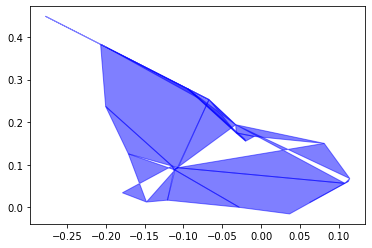

In [7]:
# plot output zonotopes
fig, ax = plt.subplots()
for z in Z_out:
    z.plot(ax)

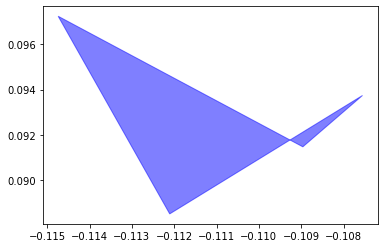

In [20]:
Z_out[5].plot()

In [14]:
torch.diag(torch.tensor([0.1,0.2]))

tensor([[0.1000, 0.0000],
        [0.0000, 0.2000]])

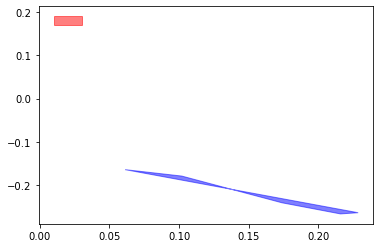

In [24]:
c_obs = torch.tensor([[0.02],[0.18]])
G_obs = torch.diag(torch.tensor([0.01,0.01]))
Z_obs = TorchConstrainedZonotope(c_obs, G_obs)

fig, ax = plt.subplots()
Z_out[2].plot(ax, 'b')
Z_obs.plot(ax, 'r')

In [28]:
con_opt = optim.SGD(net.parameters(), lr=0.1)
con_opt.zero_grad()
v = torch_collision_check(Z_out[10], Z_obs)
if v <= 1:
    v.backward()

In [19]:
optimizer = optim.SGD(net.parameters(), lr=0.1)
optimizer.step()

# Constrained training

In [ ]:
# constraint function 
# for now, something simple: constrain weights to be positive

def constraint(net):
    


In [ ]:
# train the network
optimizer = optim.SGD(net.parameters(), lr=0.1)

loss = nn.MSELoss()

num_iters = 1000

# training loop:
for i in range(num_iters):
    optimizer.zero_grad()   # zero the gradient buffers

    pred = net(X)

    output = loss(pred, Y)
    #print('loss: ', output)
    output.backward()
    optimizer.step() 